### EDIT LOG
v1 
- simple fitting into dataset first, did encoding, but wrong kinds
- performed SMOTE on train data

v2 
- encoded categorical columns
- grouped professions in the column due to high cardinality (will try with this new reduced cardinality)
- try feature selection to reduce number of columns in next version (chi-square and info gain)

v3
- tried feature selection (pca and chi-square) but the eval metrics results turn out to be worse

future
- (wip, thoughts) finetune the xgboost parameters
- include k-fold

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Reading file and tidying

#### Reading csv file

In [2]:
df = pd.read_csv("loanprediction.csv")
# df.head()

#### Drop column(s)

In [3]:
df.drop("Id", axis=1, inplace=True)
# df.drop("state", axis=1)
# df.drop("city", axis=1)

#### Renaming columns

In [4]:
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
# df.head()

#### Check the number of unique category for each categorical column

In [5]:
cat_cols = ["marital_status", "house_ownership", "car_ownership", "profession", "city", "state"]

# technology - Web_designer, Software_Developer, , Computer_operator, Technology_specialist
# medical - Physician, Microbiologist, Dentist, Surgeon, Psychologist
# analyst - Financial_Analyst, Analyst
# engineer - Computer_hardware_engineer, Industrial_Engineer, Mechanical_engineer, Chemical_engineer, Biomedical_Engineer, Petroleum_Engineer, Design_Engineer, Civil_engineer, Engineer, Technician
# aviation - Flight_attendant, Air_traffic_controller, Aviator
# government - Civil_servant, Official, Politician, Army_officer, Police_officer
# designer - Designer, Graphic_Designer, Fashion_Designer
# court - Magistrate, Lawyer
# architectural - Architect, Drafter


# 'Technical_writer',
# 'Librarian', 'Economist', 
# 'Artist', 'Surveyor', 
# 'Hotel_Manager', 'Comedian', 'Secretary', 
# 'Chartered_Accountant', 'Firefighter', 
# 'Geologist','Statistician', '
# 'Consultant', 'Chef', 'Scientist'

# Encoding categorical columns

#### Label encoding categorical columns with 2 types of categories

In [6]:
label_enc = LabelEncoder()
df["marital_status"] = label_enc.fit_transform(df["marital_status"])
df["car_ownership"] = label_enc.fit_transform(df["car_ownership"])

#### One Hot Encoding `house_ownership` column & Combining back to dataframe

In [7]:
onehot_enc = OneHotEncoder()
house_ownership_reshape = np.array(df["house_ownership"]).reshape(-1, 1)
house_ownership_values = onehot_enc.fit_transform(house_ownership_reshape).toarray().astype(int)
house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

df = df.join(house_ownership_df["norent_noown"])
df = df.join(house_ownership_df["owned"])
df = df.join(house_ownership_df["rented"])

df.drop("house_ownership", axis=1, inplace=True)

#### Target Encoding the high cardinality categorical columns: `profession`, `city`, `state`

In [8]:
# https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64
target_enc = TargetEncoder()
df["profession_encoded"] = target_enc.fit_transform(df["profession"], df["risk_flag"])

/Users/jonw/miniforge3/envs/ml_env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
target_enc = TargetEncoder()
df["city_encoded"] = target_enc.fit_transform(df["city"], df["risk_flag"])

In [10]:
target_enc = TargetEncoder()
df["state_encoded"] = target_enc.fit_transform(df["state"], df["risk_flag"])

df.drop("profession", axis=1, inplace=True)
df.drop("city", axis=1, inplace=True)
df.drop("state", axis=1, inplace=True)

#### Defining x and y (target) variables

In [11]:
y = df["risk_flag"]
x = df.drop("risk_flag", axis=1)
x.head()

,income,age,experience,marital_status,car_ownership,current_job_years,current_house_years,norent_noown,owned,rented,profession_encoded,city_encoded,state_encoded
0,1303834,23,3,1,0,3,13,0,0,1,0.111558,0.121554,0.154369
1,7574516,40,10,1,0,9,13,0,0,1,0.148427,0.122497,0.113254
2,3991815,66,4,0,0,4,10,0,0,1,0.134167,0.130814,0.167097
3,6256451,41,2,1,1,2,12,0,0,1,0.148427,0.326194,0.142550
4,5768871,47,11,1,0,3,14,0,0,1,0.115794,0.121137,0.103163


#### Perform Chi-Square for feature selection
H0 :- There is no relationship between categorical feature and target variable\
H1 :- There is some relationship between categorical feature and target variable\
If p-value ≥0.05, the null hypothesis is not rejected and there is no any relationship between target variable and categorical features.

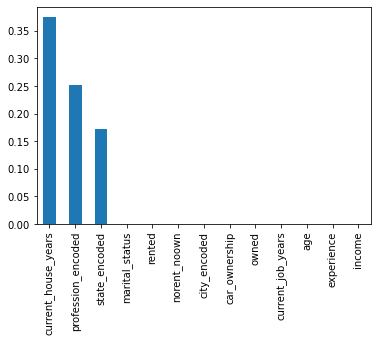

In [12]:
# https://medium.com/analytics-vidhya/categorical-feature-selection-using-chi-squared-test-e4c0d0af6b7e
# https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1

# Standardisation gives negative values, chi-square does not allow negative values

chi_scores = chi2(x,y)
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

# conclusion: current_house_years, profession_encoded, state_encoded have no relationship with target variable
x = x.drop(["current_house_years", "profession_encoded", "state_encoded"], axis=1)

#### Standardising columns

In [13]:
# # Scale all except columns which are one-hot encoded and label encoded

# # With Chi-Square
# to_scale = ["income", "age", "experience", "current_job_years", "city_encoded"]
# no_scale = ["marital_status", "car_ownership", "norent_noown", "owned", "rented"]

# # Without Chi-Square
# # to_scale = ["income", "age", "experience", "current_job_years", "current_house_years", "profession_encoded", "city_encoded", "state_encoded"]
# # no_scale = ["marital_status", "car_ownership", "norent_noown", "owned", "rented"]

# scaler = StandardScaler()
# scaled = scaler.fit_transform(x[to_scale])
# scaled_df = pd.DataFrame(data=scaled, columns=to_scale)

# for col in to_scale:
#     x[col] = scaled_df[col]
    
# x.head()

# Preparing for modelling

#### Splitting the dataset into train and test sets

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

#### Performing PCA

In [15]:
pca_loan = PCA()
x_train = pca_loan.fit_transform(x_train)
x_test = pca_loan.fit_transform(x_test)

#### Perform oversampling on train data

<AxesSubplot:xlabel='risk_flag', ylabel='count'>

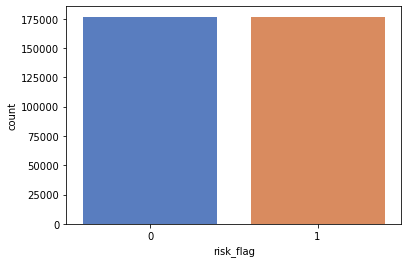

In [16]:
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

sns.countplot(x = y_train, palette = 'muted')

#### Applying xgboost model

In [17]:
# # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    use_label_encoder=False,
                    random_state=2021)

xgb.fit(x_train, y_train, eval_metric='logloss')
y_pred = xgb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[30997 13300]
 [ 3501  2602]]


In [18]:
print("-------------------------TEST SCORES-----------------------")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")

-------------------------TEST SCORES-----------------------
Recall: 0.4263476978535147
Precision: 0.1636272167023016
F1-Score: 0.23649170643035675
Accuracy score: 0.6666468253968254
AUC Score: 0.5630508157642408


#### v2
-------------------------TEST SCORES----------------------- \
Recall: 0.7781418974274946 \
Precision: 0.5386185777475332 \
F1-Score: 0.6365951742627347 \
Accuracy score: 0.892420634920635 \
AUC Score: 0.8431536179690017

#### v2: scale (not much difference)
-------------------------TEST SCORES-----------------------\
Recall: 0.7799442896935933\
Precision: 0.537185419252906\
F1-Score: 0.636193531141406\
Accuracy score: 0.891984126984127\
AUC Score: 0.8436823283806703

#### v2: scale + PCA
-------------------------TEST SCORES-----------------------\
Recall: 0.22710142552842863\
Precision: 0.17883870967741936\
F1-Score: 0.2001010611419909\
Accuracy score: 0.7801388888888889\
AUC Score: 0.5417174057682552

#### v2: chi-square + scale
-------------------------TEST SCORES-----------------------\
Recall: 0.19941012616745862\
Precision: 0.1721601358042156\
F1-Score: 0.18478590950501064\
Accuracy score: 0.7869444444444444\
AUC Score: 0.533650928492222

#### v2: chi-square
-------------------------TEST SCORES-----------------------\
Recall: 0.4263476978535147\
Precision: 0.1636272167023016\
F1-Score: 0.23649170643035675\
Accuracy score: 0.6666468253968254\
AUC Score: 0.5630508157642408